# 3- Check if any other rescaling of data or initialization of weights may improve the accuracy of the DNN.

In [2]:
import tensorflow        as tf
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns

import time
import h5py

%load_ext autoreload
%autoreload 1
%aimport nn_model
%aimport create_data
%aimport preprocess
%aimport plot_utils

## Generate data

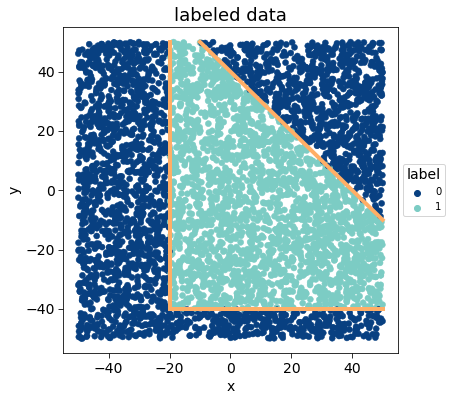

In [3]:
# number of data
N = 5000
# box size
B = 100

# random seed for reproducibility
np.random.seed(20220308)

x, y_true = create_data.create_data(N, B, c="triang")

fig = plt.figure(figsize=(6,6))
ax  = plot_utils.plot_labeled_data(
    x               = x, 
    labels          = y_true, 
    fig             = fig, 
    title           = "labeled data", 
    palette         = "GnBu_r",
    hue_norm        = (0, 2),
    fontsize        = 14, 
    show_boundaries = True
)

plt.show()

## Data rescalings

Rescaling functions can be found in ```preprocess.py```

1) No rescaling
2) Standardization
3) Normalization

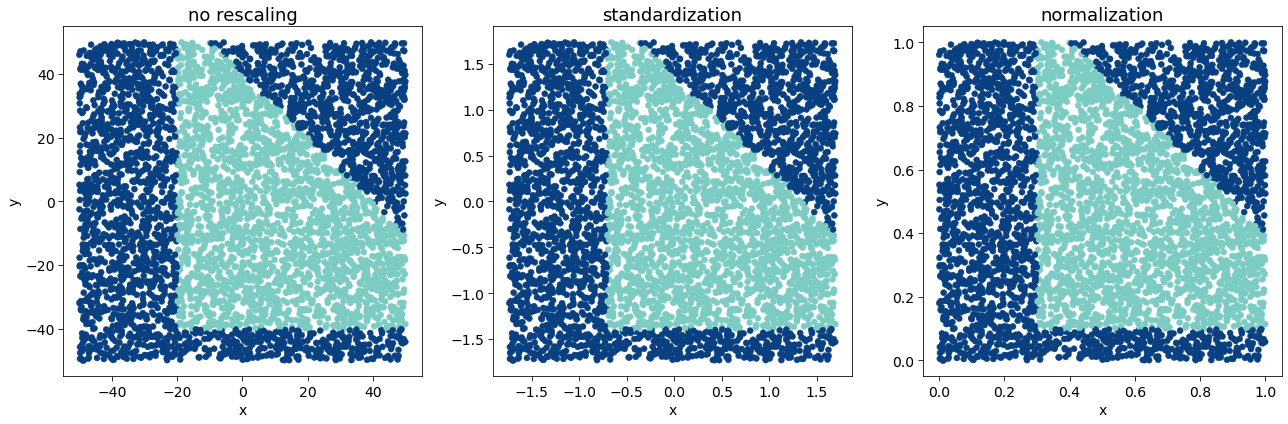

In [4]:
mean = np.mean(x, axis=0) 
std  = np.std(x, axis=0)

# no rescaling
x_nr   = np.copy(x)
# standardization
x_std  = preprocess.standardize(x, mean, std)
# normalization
x_norm = preprocess.normalize(x)

dataset = np.array([x_nr, x_std, x_norm])
titles  = ["no rescaling", "standardization", "normalization"]

fig = plt.figure(figsize=(18,6))

for i, data in enumerate(dataset):
    ax  = plot_utils.plot_labeled_data(
        x               = data, 
        labels          = y_true, 
        fig             = fig, 
        subplot_id      = 131+i,
        title           = titles[i], 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
plt.show()

### Training, test, validation

In [5]:
train_test_frac  = 0.7
valid_train_frac = 0.2 

N_train = int(N*train_test_frac*(1-valid_train_frac))
N_valid = int(N*train_test_frac*valid_train_frac)
N_test  = int(N*(1-train_test_frac))

train_idx = N_train
valid_idx = N_train + N_valid
test_idx  = N_train + N_valid + N_test

data_split = {
    "training_set"   : N_train,
    "test_set"       : N_test,
    "validation_set" : N_valid
}

for key, val in data_split.items():
    print(f"{key} \t N = {val}")

training_set      = []
training_labels   = []
test_set          = []
test_labels       = []
validation_set    = []
validation_labels = []

for data in dataset:

    training_set.append(data[0:train_idx])
    training_labels.append(y_true[0:train_idx])

    validation_set.append(data[train_idx:valid_idx])
    validation_labels.append(y_true[train_idx:valid_idx])

    test_set.append(data[valid_idx:test_idx])
    test_labels.append(y_true[valid_idx:test_idx])


training_set 	 N = 2800
test_set 	 N = 1500
validation_set 	 N = 700


### Neural network hyper-parameters

In [6]:
N_features = x.shape[1]

## NN hyperparameter

architecture      = [N_features, 20, 20, 1]
dropout_arc       = None # [1]
dropout_rates     = None # [0.2]
batch_norm_arc    = None # [2]   
input_dim         = architecture[0]
hidden_activation = "relu"
output_activation = "sigmoid"
name              = "my lovely neural network"

loss      = "binary_crossentropy"
optimizer = "adam"
metrics   = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy", threshold=0.5),
    # tf.keras.metrics.Recall(name="precision")
]

### Training

In [7]:
# training parameters
minibatch = 100
N_epochs  = 200

networks    = []
fit_results = []

for i in range(len(dataset)):

    name = f"{titles[i]} network"

    network = nn_model.create_model(
        input_dim         = input_dim,
        architecture      = architecture,
        dropout_layers    = dropout_arc,
        dropout_rates     = dropout_rates,
        batch_norm_layers = batch_norm_arc,
        hidden_activation = hidden_activation,
        output_activation = output_activation,
        loss              = loss,
        optimizer         = optimizer,
        metrics           = metrics,
        nn_name           = name,
    )

    # network.summary()

    t0 = time.time()
    fit = network.fit(
        training_set[i], training_labels[i],
        epochs          = N_epochs,
        batch_size      = minibatch,
        validation_data = (validation_set[i], validation_labels[i]),
        verbose         = 0,
    )
    t1 = time.time()

    test = network.evaluate(
        test_set[i], test_labels[i],
        batch_size      = minibatch,
        verbose         = 0,
    )


    print("="*30)
    print(f"\n{titles[i]} training : {t1-t0:.2f} seconds")

    print(f"\ntraining loss     : {fit.history['loss'][-1]:.5f}")
    print(f"training accuracy : {fit.history['accuracy'][-1]:.5f}")

    print(f"\nvalid loss        : {fit.history['val_loss'][-1]:.5f}")
    print(f"valid accuracy    : {fit.history['val_accuracy'][-1]:.5f}\n")

    print(f"\n{titles[i]} testing")

    print(f"\ntest loss         : {test[0]:.5f}")
    print(f"test accuracy     : {test[1]:.5f}\n")

    print("="*30)

    networks.append(network)
    fit_results.append(fit)


no rescaling training : 28.36 seconds

training loss     : 0.03922
training accuracy : 0.98750

valid loss        : 0.03913
valid accuracy    : 0.98857


no rescaling testing

test loss         : 0.04208
test accuracy     : 0.98600


standardization training : 41.47 seconds

training loss     : 0.02411
training accuracy : 0.99571

valid loss        : 0.02168
valid accuracy    : 0.99571


standardization testing

test loss         : 0.02548
test accuracy     : 0.99467


normalization training : 15.43 seconds

training loss     : 0.02773
training accuracy : 0.99286

valid loss        : 0.02306
valid accuracy    : 0.99714


normalization testing

test loss         : 0.02653
test accuracy     : 0.99933



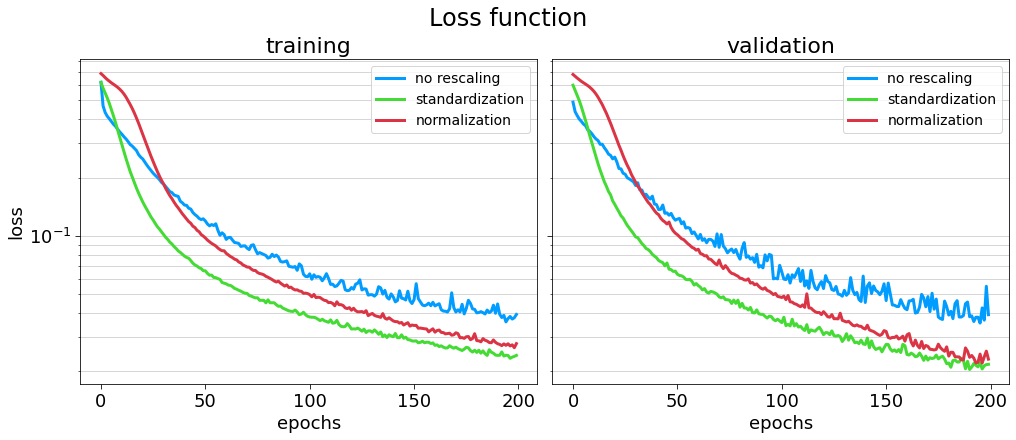

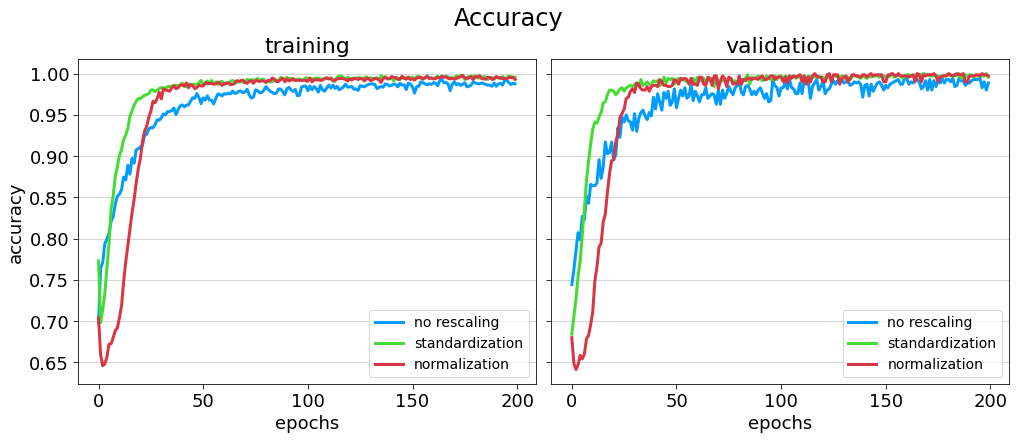

In [8]:
palette = {
    "no rescaling"   : ["#009cff", "#ff6300"],
    "standardization": ["#44db34", "#cb34db"],
    "normalization"  : ["#db3444", "#7834db"]
}

fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (14,6), 
    constrained_layout = True
)
fig.suptitle("Loss function", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2, which="both")
ax2.grid(axis="y", color="k", alpha=0.2, which="both")

for i, fit in enumerate(fit_results):

    ax1 = plot_utils.plot_loss(
        epochs     = N_epochs,
        loss       = fit.history["loss"],
        fig        = fig,
        ax         = ax1,
        color      = palette[titles[i]][0],
        loss_label = "loss",
        title      = "training",
        label      = f"{titles[i]}",
    )
    ax2 = plot_utils.plot_loss(
        epochs = N_epochs,
        loss   = fit.history["val_loss"],
        fig    = fig,
        ax     = ax2,
        color  = palette[titles[i]][0],
        title  = "validation",
        label  = f"{titles[i]}",
    )

ax1.set_yscale("log")

plt.show()


## ====================================================##


fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (14,6), 
    constrained_layout = True
)
fig.suptitle("Accuracy", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2)
ax2.grid(axis="y", color="k", alpha=0.2)

for i, fit in enumerate(fit_results):

    ax1 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = fit.history["accuracy"],
        fig          = fig,
        ax           = ax1,
        color        = palette[titles[i]][0],
        metric_label = "accuracy",
        title        = "training",
        label        = f"{titles[i]}",
    )
    ax2 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = fit.history["val_accuracy"],
        fig          = fig,
        ax           = ax2,
        color        = palette[titles[i]][0],
        title        = "validation",
        label        = f"{titles[i]}",
    )

ax1.set_yscale("linear")

plt.show()

### Weights and biases

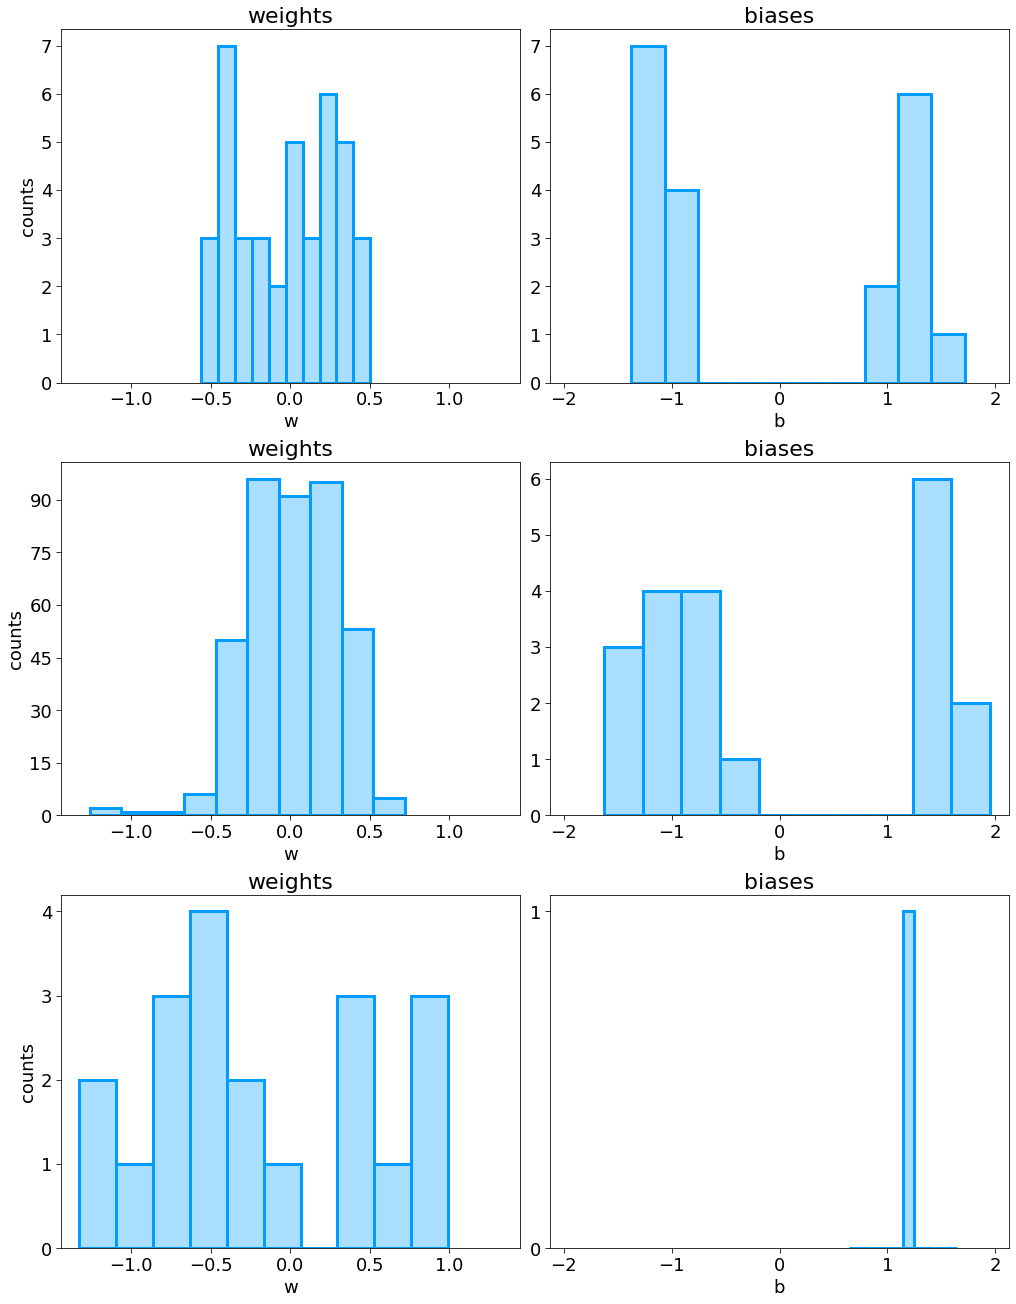

In [29]:
test_nn = networks[0]

weights = test_nn.get_weights()

axes = plot_utils.plot_weights(
    weights = weights,
    figsize = (14, 18),
)

plt.show()

### Neural network predictions

In [ ]:
grid = create_data.create_grid(B=B, dx=2)

grid_nr   = np.copy(grid)
grid_std  = preprocess.standardize(grid, np.mean(grid, axis=0), np.std(grid, axis=0))
grid_norm = preprocess.normalize(grid)

grids = np.array([grid_nr, grid_std, grid_norm])

In [ ]:
predictions        = []
binary_predictions = []

for i in range(len(dataset)):

    y_pred = networks[i].predict(grids[i])
    predictions.append(plot_utils.flatten(y_pred))

    pred_binary = y_pred.copy()
    pred_binary[y_pred <= 0.5] = 0
    pred_binary[y_pred >  0.5] = 1
    binary_predictions.append(plot_utils.flatten(pred_binary))

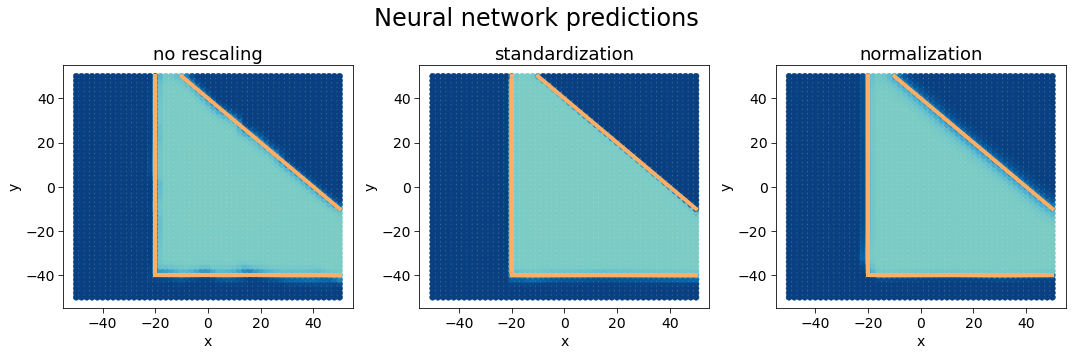

In [ ]:
fig = plt.figure(figsize=(15,5))
fig.suptitle("Neural network predictions", fontsize=24)

for i in range(len(dataset)):

    ax  = plot_utils.plot_labeled_data(
        x               = grid_nr, 
        labels          = predictions[i], 
        fig             = fig, 
        subplot_id      = 131+i,
        title           = titles[i], 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
    plot_utils.boundaries(ax)

plt.show()

---

## Weights initializers

- ```tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)```
- ```tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)```
- ```tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)```
- ```tf.keras.initializers.Zeros()```
- ```tf.keras.initializers.Ones()```
- ```tf.keras.initializers.GlorotNormal(seed=None)```
- ```tf.keras.initializers.GlorotUniform(seed=None)```
- ```tf.keras.initializers.HeNormal(seed=None)```
- ```tf.keras.initializers.HeUniform(seed=None)```
- ```tf.keras.initializers.Identity(gain=1.0)```
- ```tf.keras.initializers.VarianceScaling(scale=1.0, mode="fan_in", distribution="truncated_normal", seed=None)```

### Neural network hyper-parameters

In [ ]:
N_features = x.shape[1]

## NN hyperparameter

architecture      = [N_features, 20, 20, 1]
dropout_arc       = None # [1]
dropout_rates     = None # [0.2]
batch_norm_arc    = None # [2]   
input_dim         = architecture[0]
hidden_activation = "relu"
output_activation = "sigmoid"
initializers      = [tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5, seed=None)] 
name              = "my lovely neural network"

loss      = "binary_crossentropy"
optimizer = "adam"
metrics   = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy", threshold=0.5),
]

### Training

In [ ]:
# training parameters
minibatch = 100
N_epochs  = 200

networks    = []
fit_results = []

for i in range(len(dataset)):

    name = f"{titles[i]} network"

    network = nn_model.create_model(
        input_dim         = input_dim,
        architecture      = architecture,
        dropout_layers    = dropout_arc,
        dropout_rates     = dropout_rates,
        batch_norm_layers = batch_norm_arc,
        hidden_activation = hidden_activation,
        output_activation = output_activation,
        loss              = loss,
        optimizer         = optimizer,
        metrics           = metrics,
        nn_name           = name,
    )

    # network.summary()

    t0 = time.time()
    fit = network.fit(
        training_set[i], training_labels[i],
        epochs          = N_epochs,
        batch_size      = minibatch,
        validation_data = (validation_set[i], validation_labels[i]),
        verbose         = 0,
    )
    t1 = time.time()

    test = network.evaluate(
        test_set[i], test_labels[i],
        batch_size      = minibatch,
        verbose         = 0,
    )


    print("="*30)
    print(f"\n{titles[i]} training : {t1-t0:.2f} seconds")

    print(f"\ntraining loss     : {fit.history['loss'][-1]:.5f}")
    print(f"training accuracy : {fit.history['accuracy'][-1]:.5f}")

    print(f"\nvalid loss        : {fit.history['val_loss'][-1]:.5f}")
    print(f"valid accuracy    : {fit.history['val_accuracy'][-1]:.5f}\n")

    print(f"\n{titles[i]} testing")

    print(f"\ntest loss         : {test[0]:.5f}")
    print(f"test accuracy     : {test[1]:.5f}\n")

    print("="*30)

    networks.append(network)
    fit_results.append(fit)


no rescaling training : 21.06 seconds

training loss     : 0.04386
training accuracy : 0.98964

valid loss        : 0.04764
valid accuracy    : 0.98286


no rescaling testing

test loss         : 0.05696
test accuracy     : 0.97600


standardization training : 21.00 seconds

training loss     : 0.02101
training accuracy : 0.99500

valid loss        : 0.01704
valid accuracy    : 0.99714


standardization testing

test loss         : 0.02083
test accuracy     : 0.99467


normalization training : 21.00 seconds

training loss     : 0.03257
training accuracy : 0.98929

valid loss        : 0.02501
valid accuracy    : 0.99857


normalization testing

test loss         : 0.02959
test accuracy     : 0.99600



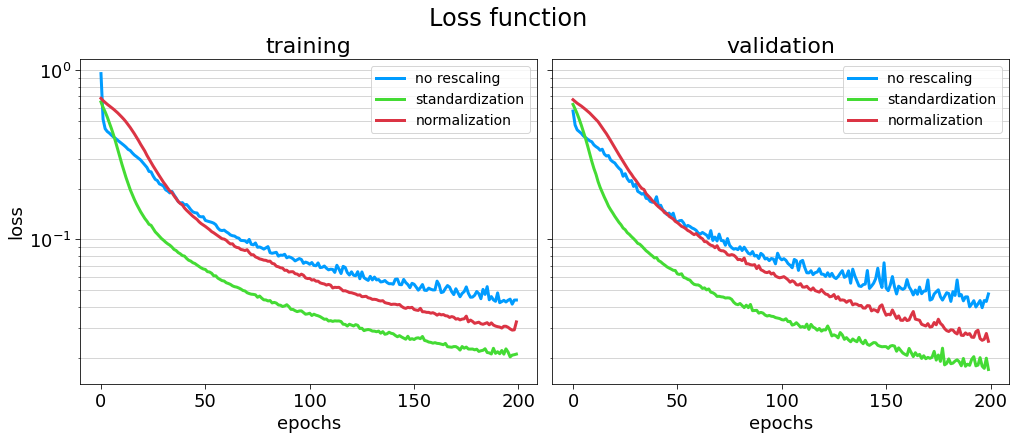

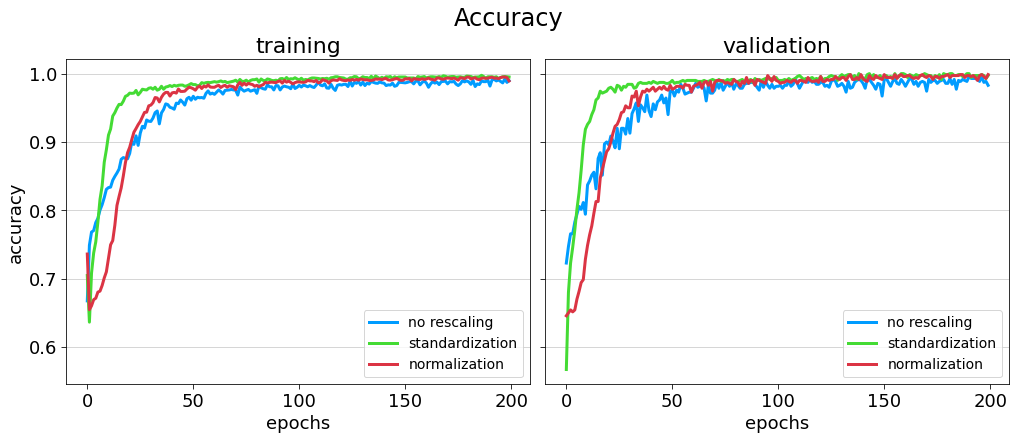

In [ ]:
palette = {
    "no rescaling"   : ["#009cff", "#ff6300"],
    "standardization": ["#44db34", "#cb34db"],
    "normalization"  : ["#db3444", "#7834db"]
}

fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (14,6), 
    constrained_layout = True
)
fig.suptitle("Loss function", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2, which="both")
ax2.grid(axis="y", color="k", alpha=0.2, which="both")

for i, fit in enumerate(fit_results):

    ax1 = plot_utils.plot_loss(
        epochs     = N_epochs,
        loss       = fit.history["loss"],
        fig        = fig,
        ax         = ax1,
        color      = palette[titles[i]][0],
        loss_label = "loss",
        title      = "training",
        label      = f"{titles[i]}",
    )
    ax2 = plot_utils.plot_loss(
        epochs = N_epochs,
        loss   = fit.history["val_loss"],
        fig    = fig,
        ax     = ax2,
        color  = palette[titles[i]][0],
        title  = "validation",
        label  = f"{titles[i]}",
    )

ax1.set_yscale("log")

plt.show()


## ====================================================##


fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (14,6), 
    constrained_layout = True
)
fig.suptitle("Accuracy", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2)
ax2.grid(axis="y", color="k", alpha=0.2)

for i, fit in enumerate(fit_results):

    ax1 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = fit.history["accuracy"],
        fig          = fig,
        ax           = ax1,
        color        = palette[titles[i]][0],
        metric_label = "accuracy",
        title        = "training",
        label        = f"{titles[i]}",
    )
    ax2 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = fit.history["val_accuracy"],
        fig          = fig,
        ax           = ax2,
        color        = palette[titles[i]][0],
        title        = "validation",
        label        = f"{titles[i]}",
    )

ax1.set_yscale("linear")

plt.show()

## Neural network predictions

In [ ]:
grid = create_data.create_grid(B=B, dx=2)

grid_nr   = np.copy(grid)
grid_std  = preprocess.standardize(grid, np.mean(grid, axis=0), np.std(grid, axis=0))
grid_norm = preprocess.normalize(grid)

grids = np.array([grid_nr, grid_std, grid_norm])

In [ ]:
predictions        = []
binary_predictions = []

for i in range(len(dataset)):

    y_pred = networks[i].predict(grids[i])
    predictions.append(plot_utils.flatten(y_pred))

    pred_binary = y_pred.copy()
    pred_binary[y_pred <= 0.5] = 0
    pred_binary[y_pred >  0.5] = 1
    binary_predictions.append(plot_utils.flatten(pred_binary))

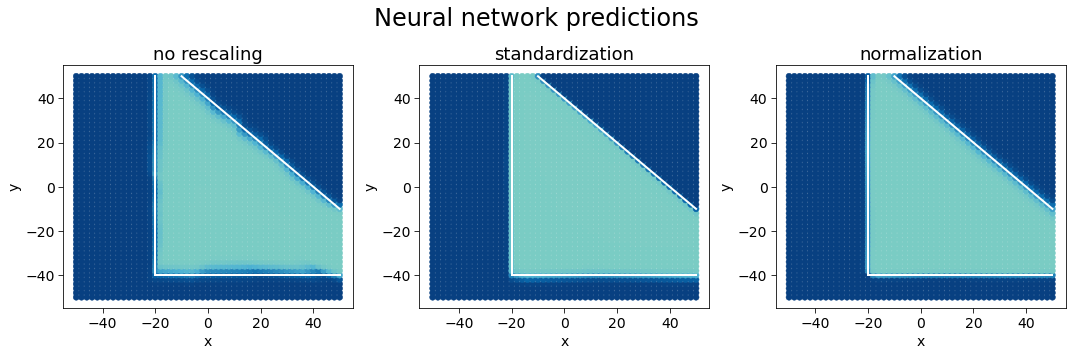

In [ ]:
fig = plt.figure(figsize=(15,5))
fig.suptitle("Neural network predictions", fontsize=24)

for i in range(len(dataset)):

    ax  = plot_utils.plot_labeled_data(
        x               = grid_nr, 
        labels          = predictions[i], 
        fig             = fig, 
        subplot_id      = 131+i,
        title           = titles[i], 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
    plot_utils.boundaries(ax, lw=2, color="w")

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=452e6836-b7b8-455e-80d9-d4109b6baddf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>